In [37]:
from textfile_data import txt_parser
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mplhep as hep
import boost_histogram as bh
from plot_classes import EmptyPlot
from matplotlib import transforms

In [30]:
data = txt_parser("tHbb_v31_v3.txt")
numeric_data = data.astype(float)
data0      = numeric_data[numeric_data[1] == 0]
data1      = numeric_data[(numeric_data[1] == 1) & (numeric_data.index != 'gamma_stat_SR_bin_9')]
data_gamma = numeric_data[numeric_data.index == 'gamma_stat_SR_bin_9']

In [81]:
class PythPullPlot(EmptyPlot):

    def __init__(self, **kwargs):        

        super().__init__(**kwargs)
        self.create_canvas()
        self.make_grid()
        self.ax = self.make_subplot(0, 1, 0, 1)
        self.set_color() # set default colormap

    def fill(self, obj):
        self.container1d.append(obj)
        self.store_data()
    
    def store_data(self):
        self.values      = [self.container1d[0][1][i] for i in range(len(self.container1d[0]))]
        self.right_bins  = [self.container1d[0][2][i] for i in range(len(self.container1d[0]))]
        self.left_bins   = [self.container1d[0][3][i] for i in range(len(self.container1d[0]))]
        self.data_labels = self.container1d[0].index.to_list()
    
    def pull_plot(self, obj):
        # hep.histplot([self.values, self.right_bins, self.left_bins], stack=True, histtype='fill', orientation='horizontal')
        """
        cannot simply use hep functions so need to manually create the pull plot
        """
        self.config_rcParams({'lines.markersize': 2}) # why does this not work at run time???? (for user)

        yvalues = np.arange(0, len(self.values))
        self.ax.scatter(self.values, yvalues, color='k')
        
        for i, y in enumerate(yvalues):
            self.ax.plot([self.left_bins[i], self.right_bins[i]], [y, y], color='k', lw=0.5)        
        
    def display(self, *save_name):
        self.pull_plot(self.container1d[0])
        
        if save_name:
            self.saveimage(save_name)

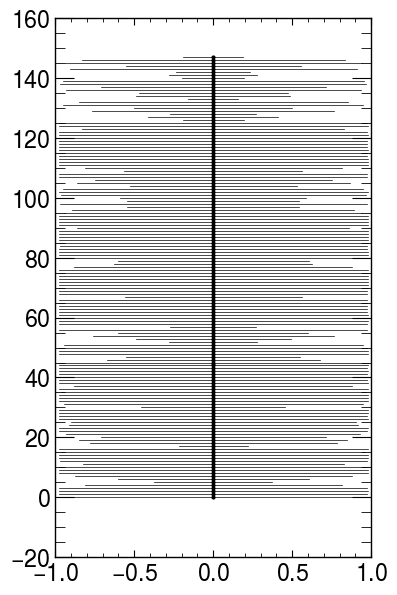

In [84]:
hist1 = PythPullPlot(size=(4,7))
hist1.fill(data0)
hist1.display()